# BayesCode estimation of amino-acids preferences 

We test the estimation of amino-acids preferences with PhyloBayes.
    1. Download newick tree and site-specific amino-acid preferences generated by deep mutational scanning in the lab 
    2. Use the data to run simulations with SimuEvol, thus obtaining alignment.
    3. Estimate omega with CodeBayes using the alignment.
    4. Compare the estimation to the original site-specific amino-acid preferences 

Requirements: 

Dataset: [Bloom 2017](https://biologydirect.biomedcentral.com/articles/10.1186/s13062-016-0172-z)

SimuEvol: https://github.com/ThibaultLatrille/SimuEvol

PhyloBayes MPI: https://github.com/bayesiancook/bayescode

DMS_tools: https://jbloomlab.github.io/dms_tools/index.html
    
## global imports,  input and output path


In [1]:
# GLOBAL IMPORTS
from IPython.display import display
from wand.image import Image as WImage
import numpy as np 
import matplotlib.pyplot as plt

current_dir = "/home/thibault/SimuEvol"
protein = "np"
exp = "cst"

alpha = 0.1
nbr_sites = 400

protein_prefs_path = "{0}/data_prefs/{1}.txt".format(current_dir, protein)
newick_path = "{0}/data_trees/{1}.newick".format(current_dir, protein)

simu_evol_path = "{0}/cmake-build-debug/SimuEvol".format(current_dir)
bc_data_path = "{0}/data_bayescode/{1}{2}".format(current_dir, protein, exp)

def dico_from_file(filename):
    tmp_dico = {}
    tmp_file = open(filename, "r")
    for line in tmp_file:
        split_line = line.split("=")
        if len(split_line) > 1:
            value = split_line[1].strip()
            try:
                tmp_dico[split_line[0]] = float(value)
            except:
                pass
    tmp_file.close()
    return tmp_dico

## Plot of the initial amino-acid preferences


Here is the selection plot /home/thibault/SimuEvol/data_figures/np.pdf


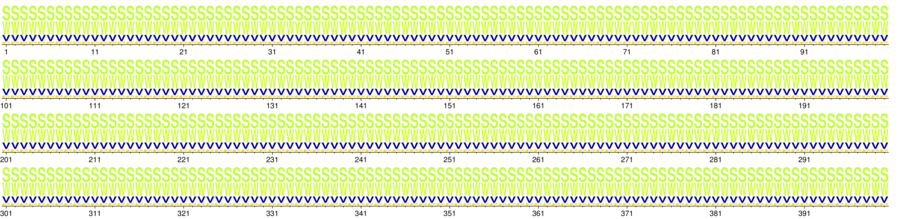

In [2]:
pref = !cat {protein_prefs_path} 
pref_str = " " + " ".join(pref[6].split(" ")[1:])
preferences = np.random.dirichlet(alpha*np.ones(20), 1)[0]
pref_str = " " + " ".join(pref[1].split(" ")[1:3]) + " "  + " ".join([str(i) for i in preferences])

prefs_path = "{0}/data_prefs/{1}_{2}.txt".format(current_dir, protein, exp)
prefs_file = open(prefs_path, 'w')
prefs_file.write(pref[0] + "\n")

for i in range(1, nbr_sites + 1):
    prefs_file.write(str(i) + pref_str + "\n")

prefs_file.close()
pdf_path = "{0}/data_figures/{1}.pdf".format(current_dir, protein)

nperline = 100
log = !dms_logoplot {prefs_path} {pdf_path} --nperline {nperline}

def plot(plot_name, size='900x'):
    print("Here is the selection plot {0}".format(plot_name))
    img = WImage(filename=plot_name, resolution=480)
    img.transform(resize=size)
    display(img)
    
plot(pdf_path)

## Forward simulation with SimuEvol

Producing an alignment in .ali and .fasta format from a preferences file and a newick tree.

## $\omega$ estimation with Hyphy

In [6]:
hyphy_path = "{0}/data_hyphy/".format(current_dir)
!rm -rf {"{0}/data_hyphy/*_hyout.txt".format(current_dir)}

import sys
sys.path.insert(0, './scripts')
from hyphy_gtr import build_hyphy_batchfile, extract_nuc_pct

nbr_points = 20
mut_bias_range = np.logspace(-1, 1, nbr_points)
mut_obs_list = np.ones(nbr_points)
mut_bias_hyphy_mut_list = np.zeros(nbr_points)

omega_true_list = np.zeros(nbr_points)
omega_obs_list = np.zeros(nbr_points)
omega_hyphy_emp_list = np.zeros(nbr_points)
omega_hyphy_mut_list = np.zeros(nbr_points)

for i, mut_bias in enumerate(mut_bias_range):
    print("Lambda={0}".format(mut_bias))
    ali_path = "{0}/data_alignment/{1}_{2}_{3}".format(current_dir, protein, alpha, mut_bias)
    mu = 20 / (1 + mut_bias)
    simu_evol_result = "{0}.txt".format(ali_path)
    !{simu_evol_path} --preferences={prefs_path} --newick={newick_path} --output={ali_path} --mu={mu} --lambda={mut_bias} --tied=false > {simu_evol_result}
    # !cat {simu_evol_result}
    
    simuevol_dico = dico_from_file(simu_evol_result)
    omega_true_list[i] = simuevol_dico["w0"]
    omega_obs_list[i] = simuevol_dico["w"]
    
    fasta_path = ali_path + ".fasta"
    nuc_freqs = extract_nuc_pct(fasta_path)
    mut_obs_list[i] = (nuc_freqs['A'] + nuc_freqs['T']) / (nuc_freqs['G'] + nuc_freqs['C'])
    print("Lambda_obs={0}".format(mut_obs_list[i]))
    print("w={0}".format(omega_true_list[i]))
    print("w_obs={0}".format(omega_obs_list[i]))
    print("")

Lambda=0.1
Lambda_obs=0.235478833845
w=0.165921
w_obs=0.184991

Lambda=0.12742749857
Lambda_obs=0.293544851871
w=0.167349
w_obs=0.199177

Lambda=0.162377673919
Lambda_obs=0.322135984134
w=0.16697
w_obs=0.197088

Lambda=0.206913808111
Lambda_obs=0.386642015253
w=0.16465
w_obs=0.204697

Lambda=0.263665089873
Lambda_obs=0.450735442273
w=0.160328
w_obs=0.173298

Lambda=0.335981828628
Lambda_obs=0.529409265671
w=0.154033
w_obs=0.172574

Lambda=0.428133239872
Lambda_obs=0.647936645991
w=0.145896
w_obs=0.181766

Lambda=0.545559478117
Lambda_obs=0.724440754283
w=0.136157
w_obs=0.159498

Lambda=0.695192796178
Lambda_obs=0.837687916351
w=0.12517
w_obs=0.149813

Lambda=0.88586679041
Lambda_obs=0.914028231916
w=0.113386
w_obs=0.137895

Lambda=1.12883789168
Lambda_obs=1.02288861001
w=0.101306
w_obs=0.118969

Lambda=1.43844988829
Lambda_obs=1.09041024301
w=0.0894313
w_obs=0.114583

Lambda=1.83298071083
Lambda_obs=1.18448811173
w=0.0782024
w_obs=0.0927919

Lambda=2.33572146909
Lambda_obs=1.2775680634

In [7]:
nucleotides = "ACGT"
codontable = {
    'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
    'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
    'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
    'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
    'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
    'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
    'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
    'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
    'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
    'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
    'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
    'TAC': 'Y', 'TAT': 'Y', 'TAA': 'X', 'TAG': 'X',
    'TGC': 'C', 'TGT': 'C', 'TGA': 'X', 'TGG': 'W'}
assert len(codontable.keys()) == 64, "There is not 64 codons in the codon table"

codons = list([k for k, v in codontable.items() if v != 'X'])
assert len(codons) == 61, "There is not 3 stop codons in the codon table"
assert not [n for n in "".join(codons) if (n not in nucleotides)], "There is a codon with an unrecognized nucleotide"

amino_acids_set = set(codontable.values())
amino_acids_set.remove('X')

nbr_weak = np.array([c.count("A") + c.count("T") for c in codons])
nbr_strong = 3. - nbr_weak


aa_char_to_int = {v: k for k, v in enumerate(sorted(amino_acids_set))}
amino_acids = "".join(amino_acids_set)
assert len(amino_acids) == 20, "There is not 21 amino-acids in the codon table"

aa_table = {}
codon_to_aa = [None] * len(codons)
for index, codon in enumerate(codons):
    aa = codontable[codon]
    if aa not in aa_table:
        aa_table[aa] = []
    aa_table[aa].append(index)
    codon_to_aa[index] = aa_char_to_int[aa]
assert len(aa_table) == 20, "There is not 21 amino-acids in the aa table"

at_pct = np.zeros(nbr_points)
gc_pct = np.zeros(nbr_points)

for mut_bias_id, mut_bias in enumerate(mut_bias_range):

    codon_frequencies = np.power(mut_bias, nbr_weak)
    pref_codons = [preferences[codon_to_aa[i]] for i in range(len(codons))]
    codon_frequencies *= np.power(pref_codons, 1)
    codon_frequencies /= np.sum(codon_frequencies)

    at_pct[mut_bias_id] = np.sum(codon_frequencies * nbr_weak)
    gc_pct[mut_bias_id] = np.sum(codon_frequencies * nbr_strong)

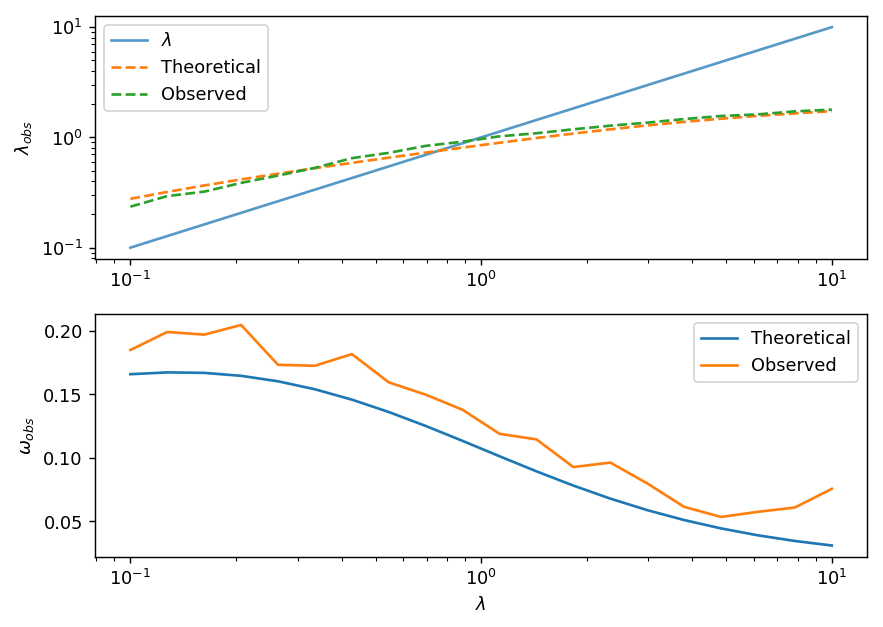

In [8]:
my_dpi = 128
fig = plt.figure(figsize=(960 / my_dpi, 720 / my_dpi), dpi=my_dpi)
plt.subplot(211)
plt.plot(mut_bias_range, mut_bias_range, alpha=0.75, label='$\lambda$')
plt.plot(mut_bias_range, at_pct / gc_pct, '--', label='Theoretical')
plt.plot(mut_bias_range, mut_obs_list, '--', label='Observed')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\lambda_{obs}$')
plt.legend()
plt.tight_layout()
plt.subplot(212)
plt.plot(mut_bias_range, omega_true_list, label='Theoretical')
plt.plot(mut_bias_range, omega_obs_list, label='Observed')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('$\omega_{obs}$')
plt.legend()
plt.tight_layout()
plt.show()